# Project 1, Part 4, Holiday Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: PRAKASH KRISHNAN

Year: 2021-2022

Semester: SPRING 2022

Section: WBL 011



# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

# Connect to the Postgres database¶
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# Create a cursor for the connection
cursor = connection.cursor()


# Format float displays in a dataframe
pd.options.display.float_format = '$ {:,.2f}'.format

# Create a one time SQL View between stores and sales table for querries in this notebook

connection.rollback()

query = """

drop view if exists v_join_s_sa;

create view v_join_s_sa
as
select s.store_id,
       s.street as store_street,
       s.city as store_city,
       s.state as store_state,
       s.zip as store_zip,
       s.latitude as store_latitude,
       s.longitude as store_longitude,
       sa.sale_id,
       sa.customer_id,
       sa.sale_date,
       extract(dow from sa.sale_date) as dow,
       to_char(sa.sale_date, 'Day') as day_of_week,
       extract(month from sa.sale_date) as month_number,
       to_char(sa.sale_date, 'Month') as month_name,
       sa.total_amount
from stores s
     join sales as sa
        on s.store_id = sa.store_id
;

"""

cursor.execute(query)

connection.commit()

## How do holidays affect the sales, considering both the actual holiday, and the days before and after the holiday? 

## Create an executive summary explaining how holidays have affected sales. 

## You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

# Executive Summary 

The approach for data exploration includes a review of sales trends for the whole year to look for seasonality trends due to holidays and also compare average sales during the holiday periods versus the non holiday period.

In looking at the 2020 calendar the following dates have been identified as Federal Holidays:

January 1, 2020 - New Year's Day
January 20, 2020 - MLK Birthday
February 17, 2020 - Washington's Birthday
May 25, 2020 - Memorial Day
July 4, 2020 - Independence Day
September 7, 2020 - Labor Day
October 12, 2020 - Columbus Day
November 11, 2020 - Veteran's Day
November 26, 2020 - Thanksgiving Day
December 25, 2020 - Christmas

For the purpose of data exploration as holiday period extend before and after the designated holidays, 3 days before and 3 days after the holiday were assumed to be extension of the holilday.

As an example for November 26, 2020 - Thanksgiving, the holiday period was defined from November 23, 2020 to November 29, 2020.

With this logic, a data set was extracted to filter days deemed as part of the holiday period and statistics were computed. The data set that did not include the holiday sales was deemed as a reference data set for baseline comparisons.

**Average Sales Amount in $ was used as a compare measure. Further the analysis was done across stores to determine any differences across stores and also different holiday periods were compared with each other to determine whether a particular holiday period had greater sales than any other holiday period.**

**Key Findings from data exploration:**

1. A review of AGM sales trend in Chart 1 for the whole year by month, shows definite spikes and valleys. There is no correlation between holidays and the associated monthly totals. As an example Thanksgiving which falls in November and Christmas that falls in December do not appear to have a positive impact on sales for the month. In addition the non holiday months such as March and August show a definite spike.

2. Table 1 and Chart 2 provide a summary of average sales for AGM for the different holiday periods and compares with the baseline non holiday period. Barring Thanksgiving, all other holiday periods have at best the same average sales as the non-holiday periods or in some cases even worse.

3. Average Sales during Thanksgiving sales (shown in blue) is higher than Average Sales in the non-holiday period for all store locations. It will be prudent to understand what was done right so as to replicate the success in future holiday periods.

4. Drop in sales during memorial week and labor day is concerning and effort must be made to understand any structural issues such as beginning for summer or end of summer vacations causing a drop in sales.

5. In aggregate terms, looking at Table 1, the average sales for the holiday period and the non-holiday period are very similar, thereby leading to a conclusion that holidays collectively dont appear have an impact either way.

**Recommendations for Management:**

1. Understand and replicate success seen during Thanksgiving Holiday Period
2. Customize meal offering through the year, especially during Holiday Periods so as to incent additional sales
3. Specific price incentives during holiday periods can be tested for elasticity of demand and sales

### AGM Sales Trend

In [3]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select month_number as month_index, month_name as month, sum(total_amount) as total_sales
from v_join_s_sa
group by month_number, month_name

"""
df=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

### Chart 1: Data Visualization of AGM Sales Trend by Month

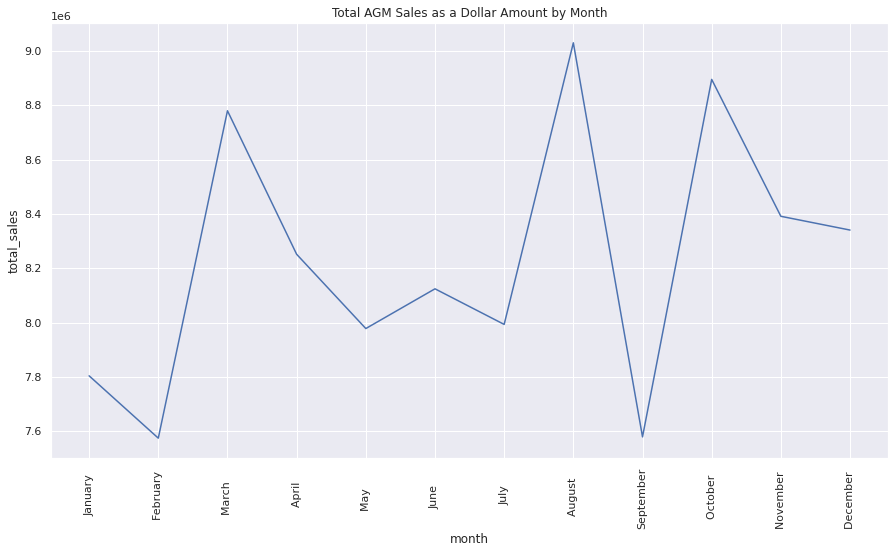

In [4]:
plt.figure(figsize=(15,8))
sns.set_theme(style="darkgrid")
sns.lineplot(x="month", y="total_sales",data=df)
plt.xticks(rotation='vertical')
plt.title("Total AGM Sales as a Dollar Amount by Month")
plt.show()

### Average Sales Comparing Holiday and Non-Holiday Periods

In [5]:
# Average Sales By Store for 2020 (Both Holiday and Non Holiday)

rollback_before_flag = True
rollback_after_flag = True

query = """

select store_city as store, avg(total_amount) as avg_all_weeks
from v_join_s_sa

group by store_city
order by store_city

"""
print("*********************************************************")
print(" Average Sales by Store for 2020 Holiday and Non Holiday ")
print("*********************************************************")
df_all=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_all

*********************************************************
 Average Sales by Store for 2020 Holiday and Non Holiday 
*********************************************************


,store,avg_all_weeks
0,Berkeley,$ 64.15
1,Dallas,$ 64.24
2,Miami,$ 64.32
3,Nashville,$ 64.00
4,Seattle,$ 64.34


In [6]:
# Average Sales for the Holiday Weeks

rollback_before_flag = True
rollback_after_flag = True

query = """

select store_city as store, avg(total_amount) as avg_holiday
from v_join_s_sa

where sale_date between '2020-01-01' and '2020-01-04' 
or
sale_date between '2020-01-17' and '2020-01-23'
or
sale_date between '2020-02-14' and '2020-02-20'
or
sale_date between '2020-05-22' and '2020-05-28'
or
sale_date between '2020-06-30' and '2020-07-06'
or
sale_date between '2020-09-04' and '2020-09-10'
or
sale_date between '2020-10-09' and '2020-10-15'
or
sale_date between '2020-11-08' and '2020-11-14'
or
sale_date between '2020-11-23' and '2020-11-29'
or
sale_date between '2020-12-22' and '2020-12-28'

group by store_city
order by store_city

"""
print("*********************************************************")
print(" Average Sales by Store for 2020 Holiday Period          ")
print("*********************************************************")

df_holidays=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_holidays

*********************************************************
 Average Sales by Store for 2020 Holiday Period          
*********************************************************


,store,avg_holiday
0,Berkeley,$ 64.24
1,Dallas,$ 64.17
2,Miami,$ 64.23
3,Nashville,$ 63.93
4,Seattle,$ 64.02


In [7]:
# Non Holiday Week Sales

rollback_before_flag = True
rollback_after_flag = True

query = """

select store_city as store, avg(total_amount) as avg_non_holiday
from v_join_s_sa

where sale_date not between '2020-01-01' and '2020-01-04' 
and
sale_date not between '2020-01-17' and '2020-01-23'
and
sale_date not between '2020-02-14' and '2020-02-20'
and
sale_date not between '2020-05-22' and '2020-05-28'
and
sale_date not between '2020-06-30' and '2020-07-06'
and
sale_date not between '2020-09-04' and '2020-09-10'
and
sale_date not between '2020-10-09' and '2020-10-15'
and
sale_date not between '2020-11-08' and '2020-11-14'
and
sale_date not between '2020-11-23' and '2020-11-29'
and
sale_date not between '2020-12-22' and '2020-12-28'

group by store_city
order by store_city

"""

print("*********************************************************")
print(" 2020 Average Sales by Store for Non Holiday Period      ")
print("*********************************************************")

df_non_holidays=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_non_holidays

*********************************************************
 2020 Average Sales by Store for Non Holiday Period      
*********************************************************


,store,avg_non_holiday
0,Berkeley,$ 64.13
1,Dallas,$ 64.25
2,Miami,$ 64.33
3,Nashville,$ 64.01
4,Seattle,$ 64.39


In [8]:
# Holiday Thanksgiving

rollback_before_flag = True
rollback_after_flag = True

query = """

select store_city as store, avg(total_amount) as avg_tksgiving
from v_join_s_sa

where
sale_date between '2020-11-23' and '2020-11-29'

group by store_city
order by store_city

"""
print("*********************************************************")
print(" 2020 Average Sales by Store for Thanksgiving Week       ")
print("*********************************************************")

df_tksgiving=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_tksgiving

*********************************************************
 2020 Average Sales by Store for Thanksgiving Week       
*********************************************************


,store,avg_tksgiving
0,Berkeley,$ 64.58
1,Dallas,$ 64.59
2,Miami,$ 64.44
3,Nashville,$ 64.40
4,Seattle,$ 64.89


In [9]:
# Christmas

rollback_before_flag = True
rollback_after_flag = True

query = """

select store_city as store, avg(total_amount) as avg_xmas
from v_join_s_sa

where
sale_date not between '2020-12-22' and '2020-12-28'

group by store_city
order by store_city

"""
print("*********************************************************")
print(" 2020 Average Sales by Store for Christmas Week          ")
print("*********************************************************")

df_xmas=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_xmas

*********************************************************
 2020 Average Sales by Store for Christmas Week          
*********************************************************


,store,avg_xmas
0,Berkeley,$ 64.15
1,Dallas,$ 64.26
2,Miami,$ 64.31
3,Nashville,$ 64.00
4,Seattle,$ 64.34


In [10]:
# July 4

rollback_before_flag = True
rollback_after_flag = True

query = """

select store_city as store, avg(total_amount) as avg_july4
from v_join_s_sa

where
sale_date not between '2020-06-30' and '2020-07-06'

group by store_city
order by store_city

"""
print("*********************************************************")
print(" 2020 Average Sales by Store for July 4 Week             ")
print("*********************************************************")

df_july4=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_july4

*********************************************************
 2020 Average Sales by Store for July 4 Week             
*********************************************************


,store,avg_july4
0,Berkeley,$ 64.15
1,Dallas,$ 64.24
2,Miami,$ 64.31
3,Nashville,$ 64.00
4,Seattle,$ 64.34


In [11]:
# Memorial Day

rollback_before_flag = True
rollback_after_flag = True

query = """

select store_city as store, avg(total_amount) as avg_mem
from v_join_s_sa

where
sale_date between '2020-05-22' and '2020-05-28'
group by store_city
order by store_city

"""
print("*********************************************************")
print(" 2020 Average Sales by Store for Memorial Day Week       ")
print("*********************************************************")

df_mem=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_mem

*********************************************************
 2020 Average Sales by Store for Memorial Day Week       
*********************************************************


,store,avg_mem
0,Berkeley,$ 63.82
1,Dallas,$ 64.46
2,Miami,$ 64.30
3,Nashville,$ 63.21
4,Seattle,$ 63.80


In [12]:
# Labor Day

rollback_before_flag = True
rollback_after_flag = True

query = """

select store_city as store, avg(total_amount) as avg_labor
from v_join_s_sa

where
sale_date between '2020-09-04' and '2020-09-10'
group by store_city
order by store_city

"""
print("*********************************************************")
print(" 2020 Average Sales by Store for Labor Day Week          ")
print("*********************************************************")

df_labor=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_labor

*********************************************************
 2020 Average Sales by Store for Labor Day Week          
*********************************************************


,store,avg_labor
0,Berkeley,$ 64.20
1,Dallas,$ 64.05
2,Miami,$ 64.30
3,Nashville,$ 64.02
4,Seattle,$ 63.60


### Build Pivot Table for Data Visualization

In [13]:
df_merge=pd.merge(df_holidays,df_non_holidays,how='inner', on=['store'])
df_merge=pd.merge(df_merge,df_mem,how='inner', on=['store'])
df_merge=pd.merge(df_merge,df_july4,how='inner', on=['store'])
df_merge=pd.merge(df_merge,df_labor,how='inner', on=['store'])
df_merge=pd.merge(df_merge,df_tksgiving,how='inner', on=['store'])
df_merge=pd.merge(df_merge,df_xmas,how='inner', on=['store'])
df_merge=df_merge.set_index('store')

### Table 1: Cross Tab of Average Sales by Store and Holiday Period

In [14]:
df_merge

,avg_holiday,avg_non_holiday,avg_mem,avg_july4,avg_labor,avg_tksgiving,avg_xmas
store,,,,,,,
Berkeley,$ 64.24,$ 64.13,$ 63.82,$ 64.15,$ 64.20,$ 64.58,$ 64.15
Dallas,$ 64.17,$ 64.25,$ 64.46,$ 64.24,$ 64.05,$ 64.59,$ 64.26
Miami,$ 64.23,$ 64.33,$ 64.30,$ 64.31,$ 64.30,$ 64.44,$ 64.31
Nashville,$ 63.93,$ 64.01,$ 63.21,$ 64.00,$ 64.02,$ 64.40,$ 64.00
Seattle,$ 64.02,$ 64.39,$ 63.80,$ 64.34,$ 63.60,$ 64.89,$ 64.34


### Chart 2: Data Visualization of Average Sales by Store and Holiday Periods

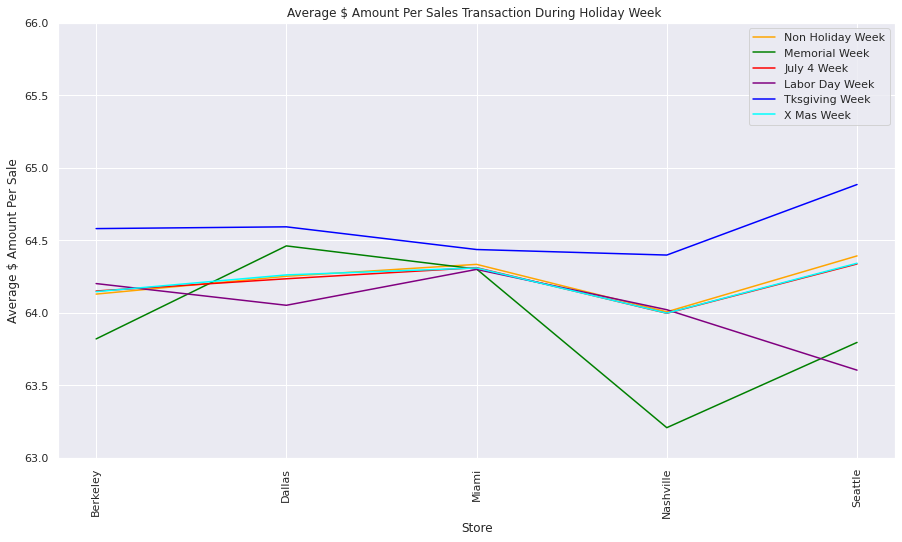

In [15]:
plt.figure(figsize=(15,8))
sns.set_theme(style="darkgrid")
sns.lineplot(x="store", y="avg_non_holiday",data=df_merge,color='orange',label='Non Holiday Week')
sns.lineplot(x="store", y="avg_mem",data=df_merge,color='green',label='Memorial Week')
sns.lineplot(x="store", y="avg_july4",data=df_merge,color='red',label='July 4 Week')
sns.lineplot(x="store", y="avg_labor",data=df_merge,color='purple',label='Labor Day Week')
sns.lineplot(x="store", y="avg_tksgiving",data=df_merge,color='blue',label='Tksgiving Week')
sns.lineplot(x="store", y="avg_xmas",data=df_merge,color='cyan',label='X Mas Week')
plt.xlabel('Store')
plt.ylabel('Average $ Amount Per Sale')
plt.xticks(rotation='vertical')
plt.title("Average $ Amount Per Sales Transaction During Holiday Week ")
plt.legend()
plt.ylim(63,66)
plt.show()